In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import fm2p

In [4]:
recdir = r'K:\Mini2P\250321_DMM_DMM037_mapRFs\map2'
stimname = 'SpatialMapping_.mat'
recname = os.path.split(recdir)[1]

In [ ]:
twop = fm2p.TwoP(recdir, recname)

stim_data = scipy.io.loadmat(os.path.join(recdir, stimname))
twop.find_files()
twop_dict = twop.calc_dFF()
dFF = twop_dict['norm_dFF'].copy()
sps = twop_dict['oasis_spks'].copy()

nF = np.size(sps, 1)
num_cells = np.size(sps, 0)
framerate = 1/twop.dt

off_time = float(stim_data['Stimdata']['offTime'][0][0][0][0])
on_time = float(stim_data['Stimdata']['onTime'][0][0][0][0])

repeats = int(stim_data['Stimdata']['numRep'][0][0][0][0])
num_x = int(stim_data['Stimdata']['num_x'][0][0][0][0])
num_y = int(stim_data['Stimdata']['num_y'][0][0][0][0])

pres_time = off_time + on_time
rep_time = pres_time * (num_x + num_y)
off_frames = round(off_time * framerate)
on_frames = round(on_time * framerate)

# Extract position lists
x_pos_list = stim_data['Stimdata']['x_pos_list'][0][0]
y_pos_list = stim_data['Stimdata']['y_pos_list'][0][0]

# Initialize response arrays
off_resp = np.zeros((num_cells, off_frames))
on_resp = np.zeros((num_cells, on_frames))

# Initialize arrays to match MATLAB dimensions
resp_x = np.zeros((num_cells, num_x, repeats))
resp_y = np.zeros((num_cells, num_y, repeats))


# Process each repetition
for rep in range(repeats):
    for pos_x in range(num_x):
        curr_pos = int(x_pos_list[rep, pos_x])
        curr_frame = round((rep*rep_time + pos_x*pres_time)*framerate)
        # Extract off and on responses
        for f in range(off_frames):
            off_resp[:, f] = dFF[:, curr_frame+f]
        for f in range(on_frames):
            on_resp[:, f] = dFF[:, curr_frame+off_frames+f]
        resp_x[:, curr_pos-1, rep] = np.mean(on_resp, axis=1) - np.mean(off_resp, axis=1)
    
    for pos_y in range(num_y):
        curr_pos = int(y_pos_list[rep, pos_y])
        curr_frame = round((rep*rep_time + (pos_y+num_x)*pres_time)*framerate)
        # Extract off and on responses
        for f in range(off_frames):
            off_resp[:, f] = dFF[:, curr_frame+f]
        for f in range(on_frames):
            on_resp[:, f] = dFF[:, curr_frame+off_frames+f]
        resp_y[:, curr_pos-1, rep] = np.mean(on_resp, axis=1) - np.mean(off_resp, axis=1)
    
    
# Average responses across repetitions
resp_x_avg = np.mean(resp_x, axis=2)
resp_y_avg = np.mean(resp_y, axis=2)

# Rectify negative response values to 0.01
for cells in range(num_cells):
    for loc in range(num_x):
        if resp_x_avg[cells, loc] < 0:
            resp_x_avg[cells, loc] = 0.01
    for loc in range(num_y):
        if resp_y_avg[cells, loc] < 0:
            resp_y_avg[cells, loc] = 0.01

# Create spatial maps with dimensions matching MATLAB (important!)
# MATLAB has spatialMap dimensions [num_y, num_x, num_cells]
spatialMap = np.zeros((num_y, num_x, num_cells))
spatialMap_norm = np.zeros((num_y, num_x, num_cells))


for i in range(num_cells):
    x_map = np.tile(resp_x_avg[i, :].reshape(-1, 1), (1, num_x))
    y_map = np.tile(resp_y_avg[i, :], (num_y, 1))
    curr_map = x_map * y_map
    spatialMap[:, :, i] = curr_map
    # Normalize
    norm_map = curr_map - np.min(curr_map)
    if np.max(norm_map) > 0:  # Avoid division by zero
        norm_map = norm_map / np.max(norm_map)
    spatialMap_norm[:, :, i] = norm_map

avg_resp_x_avg = np.mean(resp_x_avg, axis=0)
avg_resp_y_avg = np.mean(resp_y_avg, axis=0)

In [ ]:
animal_id = 'DMM037'
date = '250321'

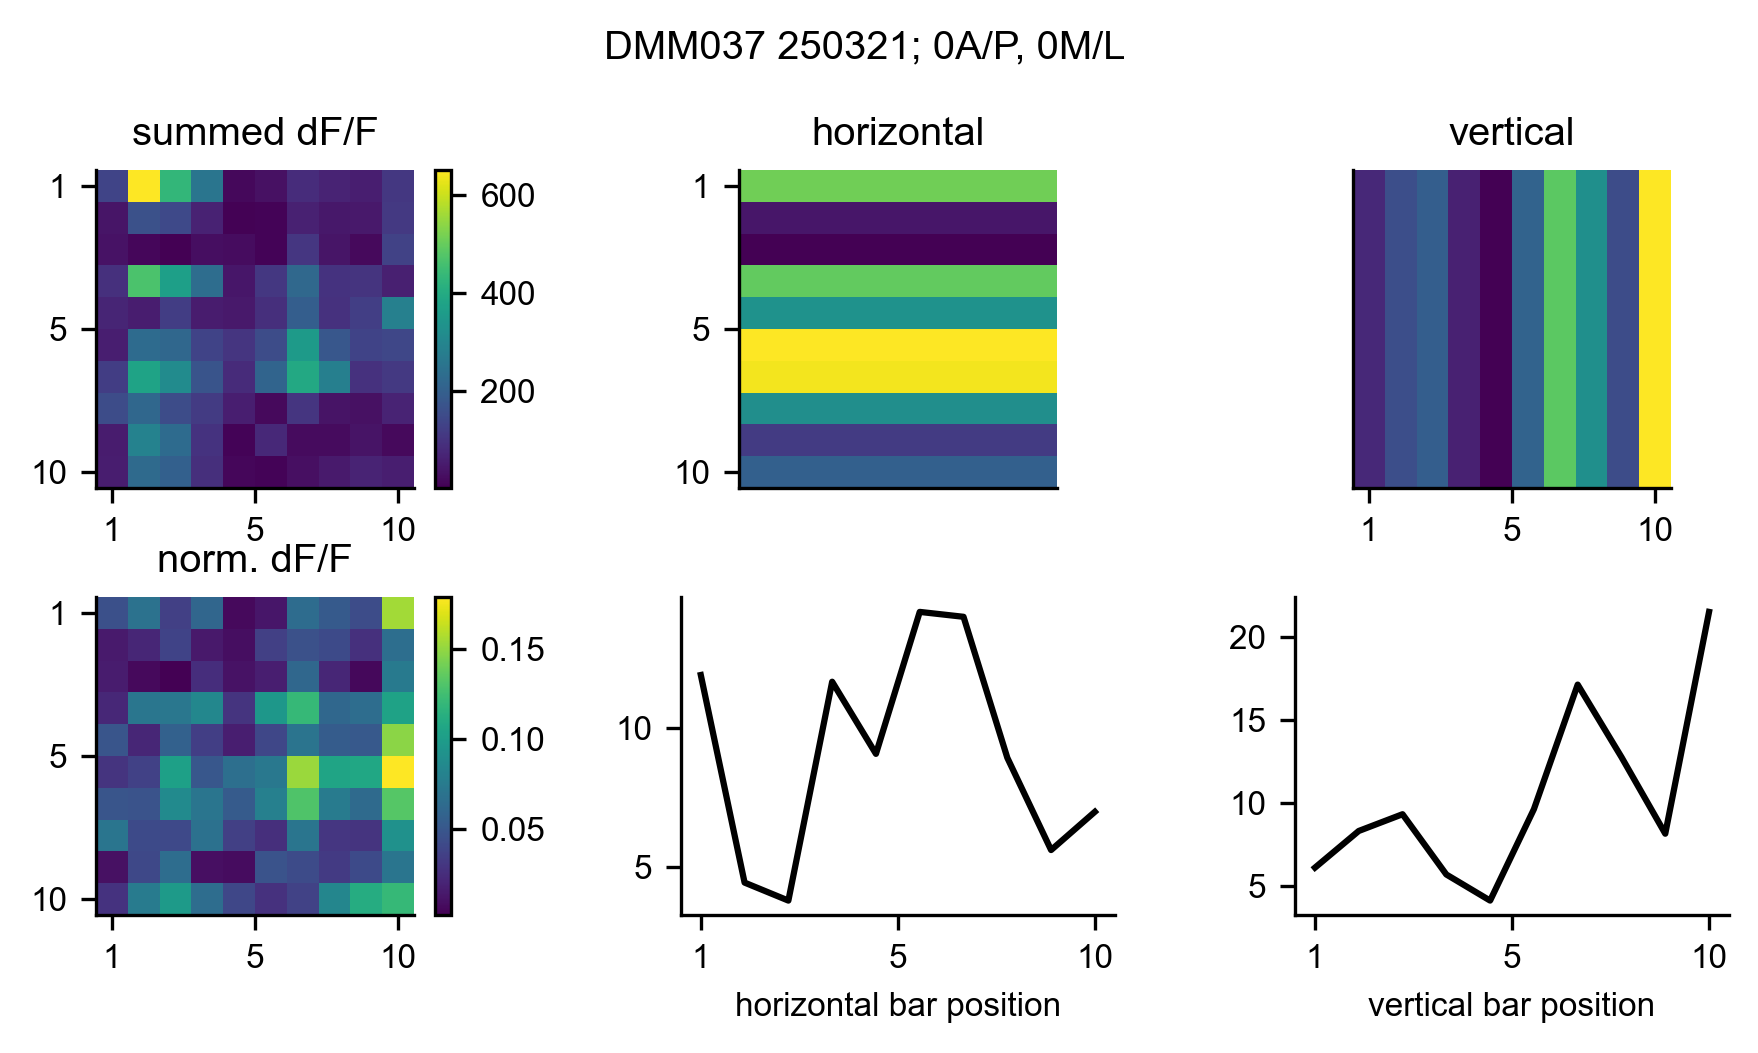

In [74]:
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3, figsize=(6,3.5), dpi=300)

im1 = ax1.imshow(np.mean(spatialMap, axis=2))
ax1.set_title('summed dF/F')
ax1.set_xticks([0,4.5,9], labels=[1,5,10])
ax1.set_yticks([0,4.5,9], labels=[1,5,10])
fig.colorbar(im1, ax=ax1)

im4 = ax4.imshow(np.nanmean(spatialMap_norm, axis=2))
ax4.set_title('norm. dF/F')
ax4.set_xticks([0,4.5,9], labels=[1,5,10])
ax4.set_yticks([0,4.5,9], labels=[1,5,10])
fig.colorbar(im4, ax=ax4)

x_map_pop = np.tile(avg_resp_x_avg.reshape(-1, 1), (1, num_y))
ax2.imshow(x_map_pop)
ax2.set_xticks([])
ax2.set_yticks([0,4.5,9], labels=[1,5,10])
ax2.set_title('horizontal')

ax5.plot(avg_resp_x_avg, 'k-')
ax5.set_xticks([0,4.5,9], labels=[1,5,10])
# ax5.set_title('horizontal')
ax5.set_xlabel('horizontal bar position')

# Plot mean response to vertical gratings
y_map_pop = np.tile(avg_resp_y_avg, (num_x, 1))
ax3.imshow(y_map_pop)
ax3.set_xticks([0,4.5,9], labels=[1,5,10])
ax3.set_yticks([])
ax3.set_title('vertical')

# Y map
ax6.plot(avg_resp_y_avg, 'k-')
ax6.set_xticks(np.arange(4, num_y, 5))
# ax6.set_title('vertical')
ax6.set_xticks([0,4.5,9], labels=[1,5,10])
ax6.set_xlabel('vertical bar position')

plt.suptitle('{} {}; 0A/P, 0M/L'.format(animal_id, date))

fig.tight_layout()
fig.savefig('{}_{}_0AP_0ML.png'.format(date, animal_id))

In [76]:
'0A/P 0M/L'.replace(' ', '_').replace(',', '_').replace('/','')

'0AP_0ML'